In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from copy import deepcopy
from typing import Callable
import seaborn as sns
from sklearn.model_selection import (
    cross_val_score,
    KFold,
    LeaveOneOut,
    StratifiedKFold,
    cross_validate,
)
from sklearn.metrics import make_scorer, roc_auc_score, accuracy_score
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, StandardScaler
from sklearn.compose import make_column_transformer
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import VarianceThreshold

from sleep_eeg.model_comparaison import *
from sleep_eeg.pre_processing.sleep_cycles import *
from sleep_eeg.pre_processing.mq import *
from sleep_eeg.plotting.sleep_cycles import *
from sleep_eeg.plotting.morning_questionnaire import *
from sleep_eeg.plotting.model_comparaison import *
from sleep_eeg.utils import *

# 0.1 Load the lantencies, continuity, age, bmi, etc... data

In [5]:
old_assembled_data, old_predictor_groups = assemble_data(
    drop_mq_grp_par_nig_dru=False, mq_class_percentiles=[0.25, 0.5, 0.75]
)

In [6]:
new_data = old_assembled_data
new_data

,bias,stage_0_to_0,stage_1_to_0,stage_0_to_1,stage_2_to_1,stage_3_to_2,stage_2_to_3,stage_5_to_2,stage_2_to_5,stage_0_to_5,...,mq_4_calm_sleep,mq_5_superficial_sleep,mq_6_recovery,mq_7_bad_mood,mq_8_energy,mq_9_tense,mq_10_unconcentrated,Age (y),"Sex (1=m, 2=f)",bmi (kg/m^2)
A01_N3,1.0,0,6,3.0,5,28,28,5.0,3.0,3.0,...,1,1,0,1,1,3,2,25.0,2.0,20.381570
A01_N4,1.0,0,11,4.0,7,25,25,7.0,4.0,7.0,...,0,3,0,3,0,3,3,25.0,2.0,20.381570
A01_N5,1.0,0,10,3.0,11,43,41,3.0,2.0,2.0,...,1,2,2,3,1,3,1,25.0,2.0,20.381570
A02_N3,1.0,0,11,3.0,14,27,24,8.0,5.0,3.0,...,0,3,1,1,2,3,0,30.0,1.0,23.299800
A02_N4,1.0,0,7,0.0,13,10,9,2.0,1.0,7.0,...,1,1,2,0,3,0,0,30.0,1.0,23.299800
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
B23_N4,1.0,0,7,0.0,9,29,29,8.0,4.0,5.0,...,2,1,2,1,3,1,0,21.0,1.0,25.057360
B23_N5,1.0,0,7,0.0,14,21,21,10.0,5.0,4.0,...,2,1,1,1,2,1,1,21.0,1.0,25.057360
B24_N3,1.0,0,15,3.0,15,39,39,8.0,4.0,7.0,...,0,2,3,0,3,1,0,27.0,1.0,23.671254
B24_N4,1.0,0,22,5.0,17,32,31,7.0,1.0,15.0,...,1,2,2,0,2,1,0,27.0,1.0,23.671254


In [ ]:
new_data = new_data[new_data["total_sleep_time"] >= 700]

new_data.drop(
    # old_predictor_groups["psd"]
    # + old_predictor_groups["fourrier"]
    old_predictor_groups["continuity"]
    + old_predictor_groups["changements"]
    + old_predictor_groups["durations_latencies"]
    + old_predictor_groups["resampled_times_series"],
    axis=1,
    inplace=True,
)  # CHANGE

# 0.4 Extract MQ info from the new data

In [12]:
mq = new_data[old_predictor_groups["mq"]]
new_data.drop(labels=old_predictor_groups["mq"], axis=1, inplace=True)
mq

C:\Users\gbrag\AppData\Local\Temp\ipykernel_24324\476590029.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_data.drop(labels=old_predictor_groups["mq"], axis=1, inplace=True)


,Group,Participant,Night,Drug,mq_1_Sleeplatency,mq_2_times_awake,mq_3_time_lay_awake,mq_4_calm_sleep,mq_5_superficial_sleep,mq_6_recovery,mq_7_bad_mood,mq_8_energy,mq_9_tense,mq_10_unconcentrated
A01_N4,A,1.0,N4,1.0,45.0,2.0,15.0,0,3,0,3,0,3,3
A01_N5,A,1.0,N5,2.0,30.0,1.0,5.0,1,2,2,3,1,3,1
A02_N3,A,2.0,N3,2.0,25.0,5.0,50.0,0,3,1,1,2,3,0
A02_N4,A,2.0,N4,0.0,24.0,5.0,53.0,1,1,2,0,3,0,0
A02_N5,A,2.0,N5,1.0,15.0,3.0,40.0,3,0,3,0,3,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
B23_N3,B,23.0,N3,0.0,5.0,3.0,15.0,3,0,2,1,3,1,0
B23_N5,B,23.0,N5,1.0,5.0,5.0,15.0,2,1,1,1,2,1,1
B24_N3,B,24.0,N3,2.0,10.0,4.0,12.0,0,2,3,0,3,1,0
B24_N4,B,24.0,N4,0.0,15.0,4.0,15.0,1,2,2,0,2,1,0


In [13]:
mq_class_weights = compute_class_weights(mq).to_dict()
mq_class_weights

c:\users\gbrag\onedrive\desktop\ml\ml-project-2-malm\sleep_eeg\pre_processing\mq.py:74: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  - mq_classified[classified_mq_cols].astype(int).apply(pd.value_counts)


{'mq_4_calm_sleep': {0: 0.7327586206896552,
  1: 0.7241379310344828,
  2: 0.8189655172413793,
  3: 0.7241379310344828},
 'mq_5_superficial_sleep': {0: 0.7327586206896552,
  1: 0.7758620689655172,
  2: 0.75,
  3: 0.7413793103448276},
 'mq_6_recovery': {0: 0.7413793103448276,
  1: 0.75,
  2: 0.7068965517241379,
  3: 0.8017241379310345},
 'mq_7_bad_mood': {0: 0.7241379310344828,
  1: 0.6724137931034483,
  2: 0.8448275862068966,
  3: 0.7586206896551724},
 'mq_8_energy': {0: 0.7413793103448276,
  1: 0.7672413793103449,
  2: 0.75,
  3: 0.7413793103448276},
 'mq_9_tense': {0: 0.7413793103448276,
  1: 0.75,
  2: 0.75,
  3: 0.7586206896551724},
 'mq_10_unconcentrated': {0: 0.7413793103448276,
  1: 0.6982758620689655,
  2: 0.8017241379310345,
  3: 0.7586206896551724}}

# 0.5 Find which columns need to be standardized, one hot encoded, min max scaled, ...

In [14]:
new_data_summary = new_data.describe()
new_data_summary

,bias,A.real1,A.real2,A.real3,A.real4,A.real5,A.imag1,A.imag2,A.imag3,A.imag4,...,stage_5_psd_f122,stage_5_psd_f123,stage_5_psd_f124,stage_5_psd_f125,stage_5_psd_f126,stage_5_psd_f127,stage_5_psd_f128,Age (y),"Sex (1=m, 2=f)",bmi (kg/m^2)
count,116.0,116.000000,116.000000,116.000000,116.000000,116.000000,116.000000,116.000000,116.000000,116.000000,...,116.000000,116.000000,116.000000,116.000000,116.000000,116.000000,116.000000,116.000000,116.000000,116.000000
mean,1.0,109.294589,109.294589,173.161369,173.161369,2259.379310,-23.151509,23.151509,-39.345583,39.345583,...,0.401753,0.409800,0.411739,0.373399,0.361144,0.376382,0.182109,26.982759,1.689655,22.780689
std,0.0,35.781694,35.781694,73.657222,73.657222,238.700965,103.565635,103.565635,135.135204,135.135204,...,0.603788,0.638630,0.533643,0.383242,0.319270,0.393185,0.216111,6.654169,0.464642,3.032332
min,1.0,38.951534,38.951534,58.308249,58.308249,1581.000000,-366.167685,-219.958895,-484.805742,-318.436312,...,0.015386,0.011427,0.030994,0.024918,0.021765,0.021014,0.002658,20.000000,1.000000,17.715420
25%,1.0,85.669643,85.669643,116.287389,116.287389,2076.000000,-74.930320,-17.878066,-94.757044,-25.594992,...,0.152919,0.129433,0.161221,0.155780,0.136589,0.136393,0.053026,23.000000,1.000000,20.195578
50%,1.0,101.987851,101.987851,158.649938,158.649938,2277.500000,-28.983362,28.983362,-31.707737,31.707737,...,0.247624,0.248955,0.248714,0.265741,0.292046,0.255492,0.110786,25.000000,2.000000,22.746914
75%,1.0,129.878218,129.878218,215.964018,215.964018,2429.750000,17.878066,74.930320,25.594992,94.757044,...,0.479283,0.459561,0.443286,0.455887,0.480443,0.486508,0.239335,28.000000,2.000000,25.013521
max,1.0,239.155491,239.155491,450.793456,450.793456,2774.000000,219.958895,366.167685,318.436312,484.805742,...,5.730782,6.131277,4.272726,2.633903,1.919776,2.226575,1.176428,45.000000,2.000000,29.425079


In [15]:
standardize_cols = (
    new_data_summary.columns.to_numpy()[np.argwhere(new_data_summary.loc["min"] < 0)]
    .flatten()
    .tolist()
)
len(standardize_cols)

9

In [16]:
ohe_cols = ["Sex (1=m, 2=f)"]
len(ohe_cols)

1

In [17]:
std_cols = new_data.columns.difference(standardize_cols + ohe_cols).to_list()
len(std_cols)

654

In [18]:
standardize_cols = standardize_cols + std_cols
len(standardize_cols) + len(ohe_cols), new_data.shape[1]

(664, 664)

# 0.6 Start the preprocessing pipeline

In [19]:
new_data.shape

(116, 664)

In [20]:
ohencoder_and_scaler = make_column_transformer(
    (OneHotEncoder(sparse_output=False, drop="if_binary"), ohe_cols),
    (StandardScaler(), standardize_cols),
    remainder="passthrough",
    verbose_feature_names_out=False,  # avoid to prepend the preprocessor names
)
ohencoder_and_scaler.set_output(transform="pandas")
constant_remover = VarianceThreshold(threshold=0.0)
constant_remover.set_output(transform="pandas")

preprocess_pipe = Pipeline(
    [
        ("ohencoder_and_scaler", ohencoder_and_scaler),
        ("constant_remover", constant_remover),
    ]
)

# Check if pipeline works
check_new_data_cleaned = preprocess_pipe.fit_transform(new_data)
check_new_data_cleaned.shape, new_data.shape

((116, 662), (116, 664))

# 1. Fit models with the preprocessing pipeline

In [21]:
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer
from skopt.plots import plot_objective


# Classification Models
from sklearn.ensemble import (
    RandomForestClassifier,
    GradientBoostingClassifier,
    AdaBoostClassifier,
)
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC, NuSVC, LinearSVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.multioutput import MultiOutputClassifier


# Regression Models
from sklearn.linear_model import (
    LinearRegression,
    LogisticRegression,
    Ridge,
    Lasso,
    ElasticNet,
    SGDRegressor,
)
from sklearn.svm import SVR, LinearSVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import AdaBoostRegressor, RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer
from skopt.plots import plot_objective

In [22]:
models_classification = [
    LogisticRegression(random_state=0, penalty=None),
    LogisticRegression(random_state=0, penalty="l1", solver="liblinear"),
    LogisticRegression(random_state=0, penalty="l2"),
    LogisticRegression(
        random_state=0, penalty="elasticnet", solver="saga", l1_ratio=0.5
    ),
    KNeighborsClassifier(),
    DecisionTreeClassifier(random_state=0),
    RandomForestClassifier(random_state=0),
    AdaBoostClassifier(random_state=0),
    SVC(random_state=0),
    LinearSVC(random_state=0),
    # NuSVC(random_state=0),
]
search_spaces_per_model_classification = [
    {"C": Real(1e-1, 1e2, "log-uniform")},
    {"C": Real(1e-1, 1e2, "log-uniform")},
    {"C": Real(1e-1, 1e2, "log-uniform")},
    {"C": Real(1e-1, 1e2, "log-uniform"), "l1_ratio": Real(0.0, 1.0)},
    {"n_neighbors": Integer(1, 50)},
    {"max_depth": Integer(1, 20)},
    {"max_depth": Integer(1, 20), "n_estimators": Integer(50, 300)},
    {"learning_rate": Real(1e-3, 1, "log-uniform"), "n_estimators": Integer(50, 300)},
    {
        "kernel": Categorical(["linear", "poly", "rbf", "sigmoid"]),
        "C": Real(1e-1, 1e2, "log-uniform"),
    },
    {"C": Real(1e-1, 1e2, "log-uniform")},
    # {"kernel":Categorical(['linear', 'poly', 'rbf', 'sigmoid']), "nu": Real(0.2, 1)}, # Infeasible apprently
]

In [23]:
# REgression
models_regression = [
    LinearRegression(),
    Ridge(random_state=0),
    Lasso(random_state=0),
    ElasticNet(random_state=0),
    DecisionTreeRegressor(random_state=0),
    RandomForestRegressor(random_state=0),
    AdaBoostRegressor(random_state=0),
    SVR(),
    LinearSVR(),
]

search_spaces_per_model_regression = [
    {"fit_intercept": Categorical([True, False])},
    {"alpha": (1e-17, 1e-8, "log-uniform")},  # Ridge
    {"alpha": (1e-17, 0.1, "log-uniform")},  # Lasso
    {
        "alpha": (1e-25, 1e-15, "log-uniform"),
        "l1_ratio": (0.001, 0.99999, "uniform"),
    },  # ElasticNet
    {"max_depth": Integer(1, 20)},  # DecisionTreeRegressor
    {
        "max_depth": Integer(1, 20),
        "n_estimators": Integer(50, 300),
    },  # RandomForestRegressor
    {
        "learning_rate": Real(1e-3, 1, "log-uniform"),
        "n_estimators": Integer(50, 300),
    },  # AdaBoostRegressor
    {
        "kernel": ("linear", "poly", "rbf", "sigmoid"),
        "degree": Integer(1, 5),
        "C": Real(1e-6, 1e3, prior="log-uniform"),
        "gamma": Real(1e-6, 1e2),
        "coef0": [0.0, 0.1, 0.5, 1.0],
    },
    {"C": Real(1e-1, 1e3, "log-uniform")},
]
len(models_regression), len(search_spaces_per_model_regression)

(9, 9)

In [ ]:
models = models_regression
search_spaces_per_model = search_spaces_per_model_regression
len(models), len(search_spaces_per_model)

In [24]:
# best_params_across_mqs_and_models.to_csv("ss_clf_hyp_iteration1.csv")

In [25]:
def lasso_ridge_logistic_naming(model):
    if model.__class__.__name__ == "LogisticRegression":
        return f"LogisticRegression__penalty={model.penalty}"
    else:
        return model.__class__.__name__

In [26]:
CV_scores_across_mqs = fit_models_get_CV_scores_across_mqs(
    models=models,
    X=new_data,
    ys=mq.drop(mq.index.difference(new_data.index)).drop(
        [
            "Group",
            "Participant",
            "Night",
            "Drug",
            # "mq_1_Sleeplatency",
            # "mq_2_times_awake",
            # "mq_3_time_lay_awake",
            "mq_4_calm_sleep",
            "mq_5_superficial_sleep",
            "mq_6_recovery",
            "mq_7_bad_mood",
            "mq_8_energy",
            "mq_9_tense",
            "mq_10_unconcentrated",
        ],
        axis=1,
    ),
    cv=KFold(n_splits=5, shuffle=True, random_state=0),
    scoring={
        "neg_root_mean_squared_error": "neg_root_mean_squared_error",
        # "accuracy": "accuracy",
        # "f1": "f1_weighted",
        # "precision":"precision_weighted",
        # "recall":"recall_weighted"
    },
    preprocessing_pipe=preprocess_pipe,
    class_weights=None,  # mq_class_weights,
    model_naming=lasso_ridge_logistic_naming,
)
CV_scores_across_mqs["test_neg_root_mean_squared_error"] = -CV_scores_across_mqs[
    "test_neg_root_mean_squared_error"
]
CV_scores_across_mqs["train_neg_root_mean_squared_error"] = -CV_scores_across_mqs[
    "train_neg_root_mean_squared_error"
]
CV_scores_across_mqs

Evaluating model: LinearRegression


Evaluating model: Ridge
Evaluating model: Lasso
Evaluating model: ElasticNet
Evaluating model: DecisionTreeRegressor
Evaluating model: RandomForestRegressor
Evaluating model: AdaBoostRegressor
Evaluating model: SVR
Evaluating model: LinearSVR


c:\Users\gbrag\miniconda3\envs\sleep\Lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
c:\Users\gbrag\miniconda3\envs\sleep\Lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
c:\Users\gbrag\miniconda3\envs\sleep\Lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
c:\Users\gbrag\miniconda3\envs\sleep\Lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
c:\Users\gbr

Evaluating model: LinearRegression
Evaluating model: Ridge
Evaluating model: Lasso
Evaluating model: ElasticNet
Evaluating model: DecisionTreeRegressor
Evaluating model: RandomForestRegressor
Evaluating model: AdaBoostRegressor
Evaluating model: SVR
Evaluating model: LinearSVR


c:\Users\gbrag\miniconda3\envs\sleep\Lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
c:\Users\gbrag\miniconda3\envs\sleep\Lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
c:\Users\gbrag\miniconda3\envs\sleep\Lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
c:\Users\gbrag\miniconda3\envs\sleep\Lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
c:\Users\gbr

Evaluating model: LinearRegression
Evaluating model: Ridge
Evaluating model: Lasso
Evaluating model: ElasticNet
Evaluating model: DecisionTreeRegressor
Evaluating model: RandomForestRegressor
Evaluating model: AdaBoostRegressor
Evaluating model: SVR
Evaluating model: LinearSVR


c:\Users\gbrag\miniconda3\envs\sleep\Lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
c:\Users\gbrag\miniconda3\envs\sleep\Lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
c:\Users\gbrag\miniconda3\envs\sleep\Lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
c:\Users\gbrag\miniconda3\envs\sleep\Lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
c:\Users\gbr

,model,fold,fit_time,test_neg_root_mean_squared_error,train_neg_root_mean_squared_error,y_name
0,LinearRegression,0,0.046933,25.355,0.0,mq_1_Sleeplatency
1,LinearRegression,1,0.040746,13.283569,0.0,mq_1_Sleeplatency
2,LinearRegression,2,0.0456,22.808819,0.0,mq_1_Sleeplatency
3,LinearRegression,3,0.038336,21.390994,0.0,mq_1_Sleeplatency
4,LinearRegression,4,0.046946,19.341388,0.0,mq_1_Sleeplatency
...,...,...,...,...,...,...
130,LinearSVR,0,0.032911,42.789014,0.002504,mq_3_time_lay_awake
131,LinearSVR,1,0.033089,28.666383,4.92981,mq_3_time_lay_awake
132,LinearSVR,2,0.03972,22.778681,5.985645,mq_3_time_lay_awake
133,LinearSVR,3,0.066336,30.14882,4.717805,mq_3_time_lay_awake


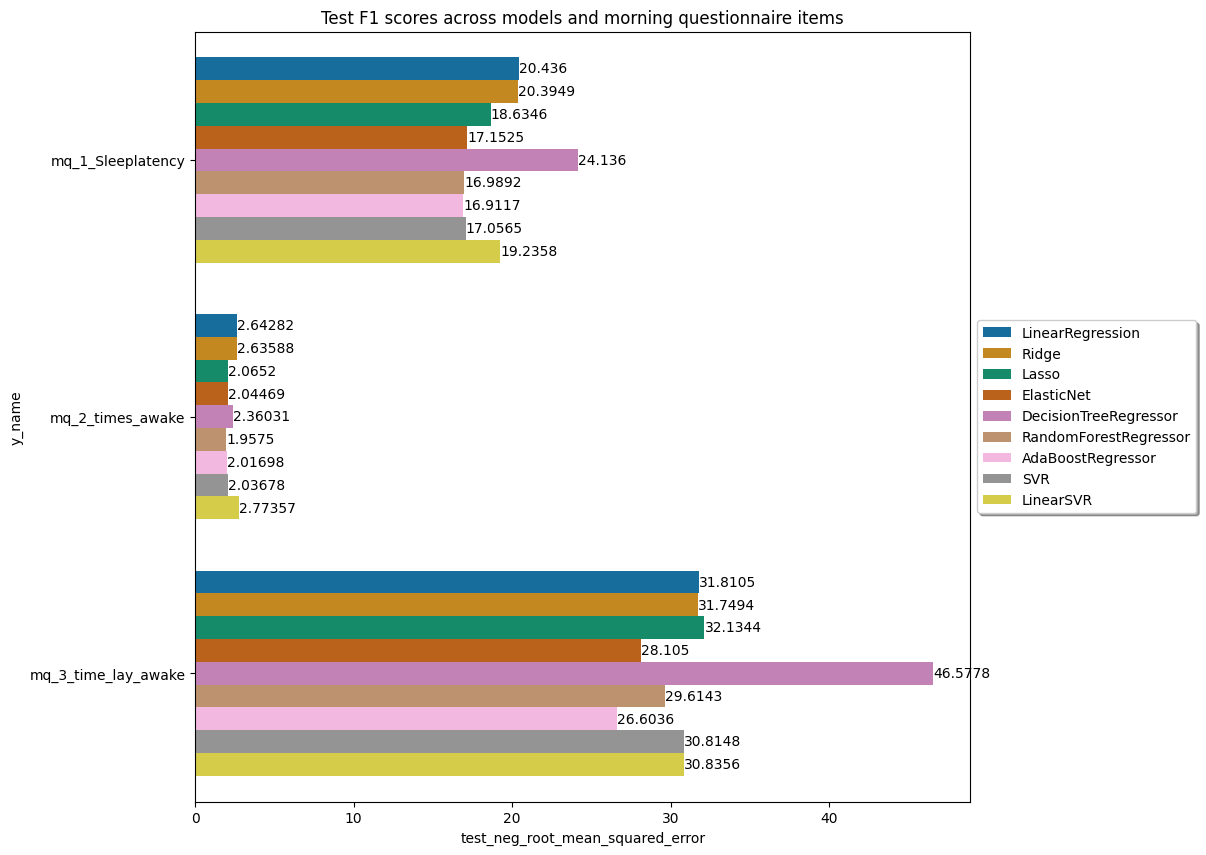

In [28]:
plt.figure(figsize=(10, 10))
# ax = sns.barplot(
#     data=CV_scores_across_mqs.melt(id_vars=['model', 'fold'], var_name='measurement', value_name='value'),
#     x="model",
#     y="value",
#     hue="measurement"
# )
# ax.set_xticklabels(labels = ax.get_xticklabels() ,rotation = 45, ha="right")
ax = sns.barplot(
    data=CV_scores_across_mqs,
    y="y_name",
    x="test_neg_root_mean_squared_error",
    hue="model",
    # legend=False,
    palette="colorblind",
    errorbar=None,
)
for i in ax.containers:
    ax.bar_label(
        i,
    )
ax.legend(loc="center left", bbox_to_anchor=(1, 0.5), fancybox=True, shadow=True)
plt.title("Test F1 scores across models and morning questionnaire items")
plt.show()

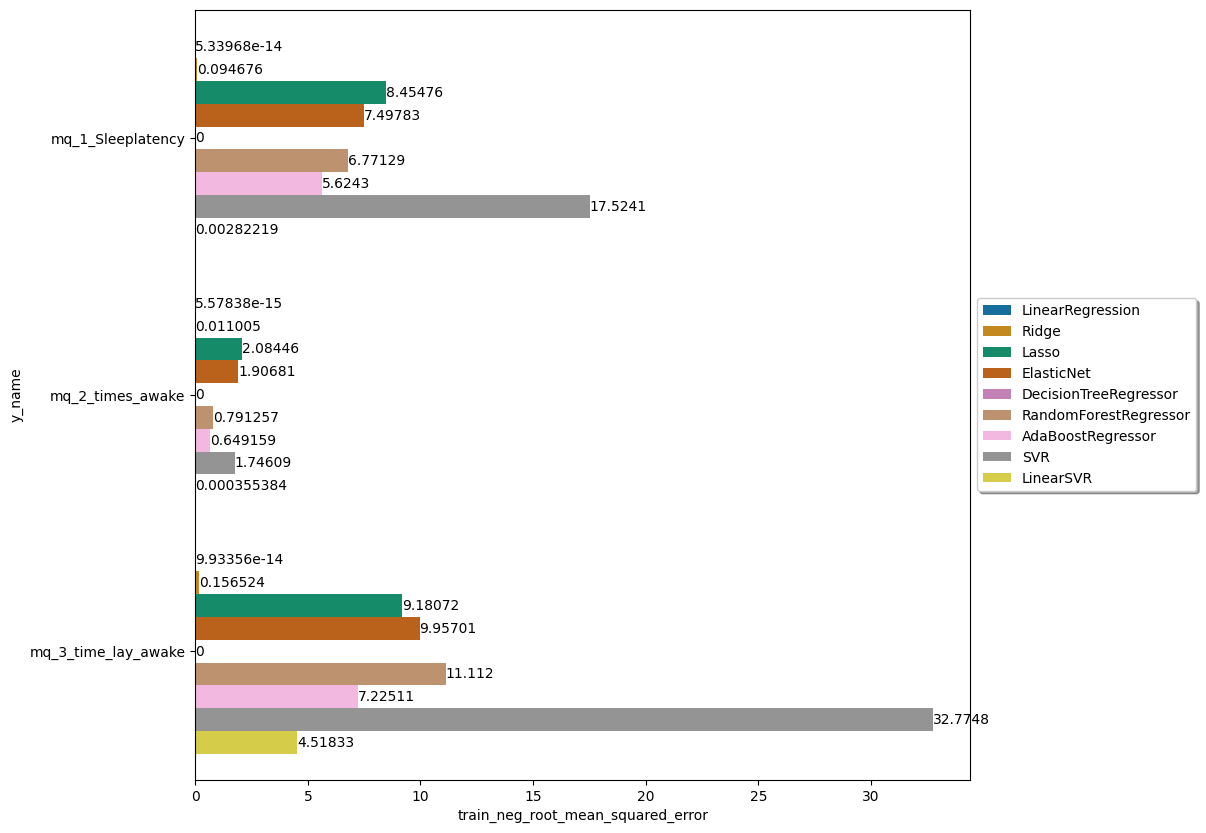

In [29]:
plt.figure(figsize=(10, 10))
# ax = sns.barplot(
#     data=CV_scores_across_mqs.melt(id_vars=['model', 'fold'], var_name='measurement', value_name='value'),
#     x="model",
#     y="value",
#     hue="measurement"
# )
# ax.set_xticklabels(labels = ax.get_xticklabels() ,rotation = 45, ha="right")
ax = sns.barplot(
    data=CV_scores_across_mqs,
    y="y_name",
    x="train_neg_root_mean_squared_error",
    hue="model",
    # legend=False,
    palette="colorblind",
    errorbar=None,
)
for i in ax.containers:
    ax.bar_label(
        i,
    )
ax.legend(loc="center left", bbox_to_anchor=(1, 0.5), fancybox=True, shadow=True)
plt.show()

In [30]:
import warnings

warnings.filterwarnings("ignore")
(
    optimised_CV_scores_across_mqs,
    best_params_across_mqs_and_models,
) = optimise_models_get_CV_scores_across_mqs(
    models=models,
    search_spaces_per_model=search_spaces_per_model,
    X=new_data,
    ys=mq.drop(mq.index.difference(new_data.index)).drop(
        [
            "Group",
            "Participant",
            "Night",
            "Drug",
            # "mq_1_Sleeplatency",
            # "mq_2_times_awake",
            # "mq_3_time_lay_awake",
            "mq_4_calm_sleep",
            "mq_5_superficial_sleep",
            "mq_6_recovery",
            "mq_7_bad_mood",
            "mq_8_energy",
            "mq_9_tense",
            "mq_10_unconcentrated",
        ],
        axis=1,
    ),
    cv=KFold(n_splits=5, shuffle=True, random_state=0),
    scoring="neg_root_mean_squared_error",
    n_iter=2,
    preprocessing_pipe=preprocess_pipe,
    class_weights=None,  # mq_class_weights,
    model_naming=lasso_ridge_logistic_naming,
)
warnings.filterwarnings("default")
optimised_CV_scores_across_mqs["test_score"] = -optimised_CV_scores_across_mqs[
    "test_score"
]
optimised_CV_scores_across_mqs["train_score"] = -optimised_CV_scores_across_mqs[
    "train_score"
]
optimised_CV_scores_across_mqs

Evaluating model: LinearRegression
Evaluating model: Ridge
Evaluating model: Lasso
Evaluating model: ElasticNet
Evaluating model: DecisionTreeRegressor
Evaluating model: RandomForestRegressor
Evaluating model: AdaBoostRegressor
Evaluating model: SVR
Evaluating model: LinearSVR
Evaluating model: LinearRegression
Evaluating model: Ridge
Evaluating model: Lasso
Evaluating model: ElasticNet
Evaluating model: DecisionTreeRegressor
Evaluating model: RandomForestRegressor
Evaluating model: AdaBoostRegressor
Evaluating model: SVR
Evaluating model: LinearSVR
Evaluating model: LinearRegression
Evaluating model: Ridge
Evaluating model: Lasso
Evaluating model: ElasticNet
Evaluating model: DecisionTreeRegressor
Evaluating model: RandomForestRegressor
Evaluating model: AdaBoostRegressor
Evaluating model: SVR
Evaluating model: LinearSVR


,model,fold,test_score,train_score,y_name
0,LinearRegression,0,25.355,0.0,mq_1_Sleeplatency
1,LinearRegression,1,13.283569,0.0,mq_1_Sleeplatency
2,LinearRegression,2,22.808819,0.0,mq_1_Sleeplatency
3,LinearRegression,3,21.390994,0.0,mq_1_Sleeplatency
4,LinearRegression,4,19.341388,0.0,mq_1_Sleeplatency
...,...,...,...,...,...
130,LinearSVR,0,42.789061,0.003037,mq_3_time_lay_awake
131,LinearSVR,1,29.20351,3.586238,mq_3_time_lay_awake
132,LinearSVR,2,23.257618,4.689856,mq_3_time_lay_awake
133,LinearSVR,3,30.623198,3.299943,mq_3_time_lay_awake


In [31]:
optimised_CV_scores_across_mqs.to_csv("ss_reg_CV_scores_opti_frequency.csv")  # CHANGE
best_params_across_mqs_and_models.to_csv("ss_reg_hyp_opti_frequency.csv")
best_params_across_mqs_and_models

,model,hyp_mq_1_Sleeplatency,train_score_mq_1_Sleeplatency,test_score_mq_1_Sleeplatency,hyp_mq_2_times_awake,train_score_mq_2_times_awake,test_score_mq_2_times_awake,hyp_mq_3_time_lay_awake,train_score_mq_3_time_lay_awake,test_score_mq_3_time_lay_awake
0,LinearRegression,[{'model__fit_intercept': True}],0.0,20.435954,[{'model__fit_intercept': True}],0.0,2.642819,[{'model__fit_intercept': True}],0.0,31.810462
1,Ridge,[{'model__alpha': 6.007274600371155e-13}],0.0,20.441526,[{'model__alpha': 6.007274600371155e-13}],0.0,2.641884,[{'model__alpha': 6.007274600371155e-13}],0.0,31.80845
2,Lasso,[{'model__alpha': 3.12915185244766e-09}],0.002607,19.769755,[{'model__alpha': 3.12915185244766e-09}],0.000311,2.534213,[{'model__alpha': 3.12915185244766e-09}],0.003087,34.549198
3,ElasticNet,"[{'model__alpha': 2.0400539352572806e-20, 'mod...",0.002607,19.769755,"[{'model__alpha': 2.0400539352572806e-20, 'mod...",0.000311,2.534214,"[{'model__alpha': 2.0400539352572806e-20, 'mod...",0.003087,34.549198
4,DecisionTreeRegressor,[{'model__max_depth': 6}],3.939849,23.496985,[{'model__max_depth': 11}],-0.0,2.360308,[{'model__max_depth': 11}],0.290851,48.193962
5,RandomForestRegressor,"[{'model__max_depth': 6, 'model__n_estimators'...",6.88644,16.838142,"[{'model__max_depth': 6, 'model__n_estimators'...",0.794256,1.961692,"[{'model__max_depth': 6, 'model__n_estimators'...",11.008849,29.473465
6,AdaBoostRegressor,[{'model__learning_rate': 0.039164491742617644...,6.437391,16.602444,[{'model__learning_rate': 0.039164491742617644...,0.753151,1.989752,[{'model__learning_rate': 0.039164491742617644...,7.867638,27.960679
7,SVR,"[{'model__C': 0.06007274600371167, 'model__coe...",17.973384,17.090287,"[{'model__C': 0.06007274600371167, 'model__coe...",2.210942,2.099469,"[{'model__C': 0.06007274600371167, 'model__coe...",33.215844,30.951272
8,LinearSVR,[{'model__C': 1.0801564116460842}],0.0027,19.235401,[{'model__C': 13.300153699806186}],0.000334,2.773538,[{'model__C': 1.0801564116460842}],3.452415,31.168378


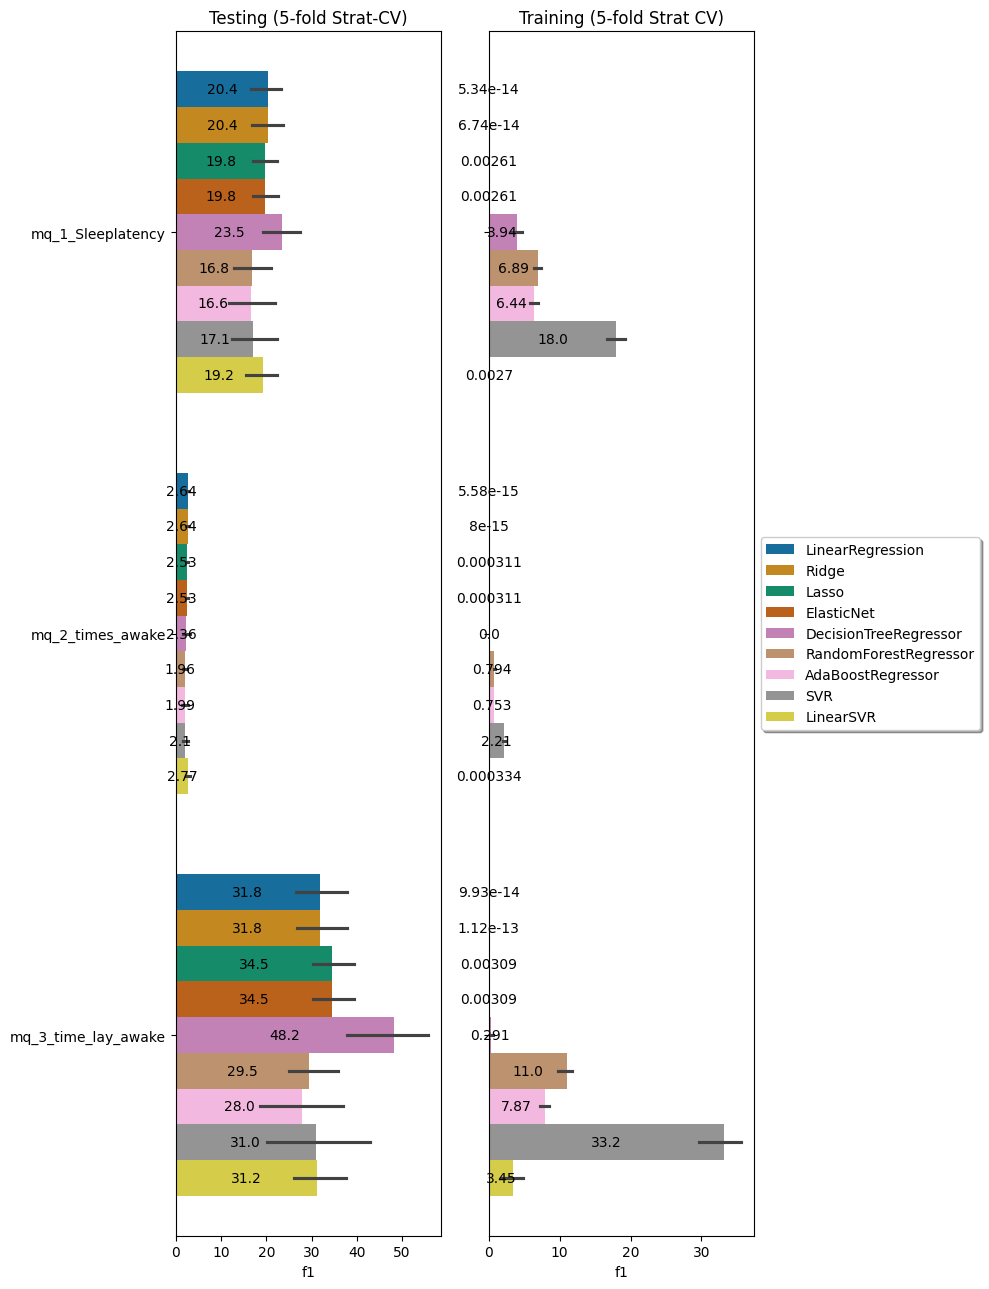

In [32]:
fig, axes = plt.subplots(ncols=2, figsize=(10, 13))  # , sharex=True)
sns.barplot(
    data=optimised_CV_scores_across_mqs,
    y="y_name",
    x="test_score",
    hue="model",
    legend=False,
    palette="colorblind",
    # errorbar=None,
    ax=axes[0],
)
for i in axes[0].containers:
    axes[0].bar_label(i, label_type="center", fmt="{:.3}")
axes[0].set_xlabel("f1")
axes[0].set_ylabel("")
axes[0].set_title("Testing (5-fold Strat-CV)")
# axes[0].legend(loc="center left", bbox_to_anchor=(1, 0.5), fancybox=True, shadow=True)

sns.barplot(
    data=optimised_CV_scores_across_mqs,
    y="y_name",
    x="train_score",
    hue="model",
    # legend=False,
    palette="colorblind",
    # errorbar=None,
    ax=axes[1],
)
for i in axes[1].containers:
    axes[1].bar_label(i, label_type="center", fmt="{:.3}")
axes[1].set_xlabel("f1")
axes[1].set_title("Training (5-fold Strat CV)")
axes[1].set_ylabel("")
axes[1].set_yticklabels([])
axes[1].legend(loc="center left", bbox_to_anchor=(1, 0.5), fancybox=True, shadow=True)
plt.tight_layout()
plt.savefig("../figures/tuned_models_test_train_f1.png", dpi=400, bbox_inches="tight")
plt.show()